# Задание 

В файле `mnist_784.csv` находится классический набор данных с картинками рукописных цифр. 

In [2]:
import pandas as pd
import numpy as np
mnist = pd.read_csv("mnist_784.csv")

In [7]:
pic = np.array(mnist.drop('class', axis=1).loc[0])

In [59]:
%matplotlib inline

import matplotlib.pyplot as plt

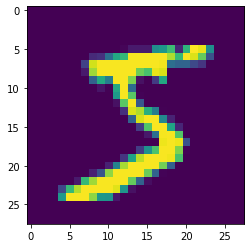

In [9]:
plt.imshow(pic.reshape(28, 28))

Необходимо применить PCA к набору данных и найти 10 первых главных компонент. Важно - в наборе данных есть колонка `class` - она очевидно не должна включаться в качестве признака, ее нужно вначале удалить из набора данных. Результат необходимо сохранить в файле `result.json`.

## PCA на sklearn

In [3]:
X = mnist.drop('class', axis=1)

In [46]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=10, random_state=0)

In [47]:
%%time
pca.fit(X)

CPU times: user 8.77 s, sys: 5.26 s, total: 14 s
Wall time: 7.9 s


TruncatedSVD(n_components=10, random_state=0)

## PCA на spark

In [4]:
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAppName("CourseraLocalSpark").setMaster("local[*]")
sc = pyspark.SparkContext.getOrCreate(conf)
spark = SparkSession.builder.appName('PCA-examples').getOrCreate()

In [5]:
data = spark.createDataFrame(X)

In [8]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=data.columns, outputCol='features')
df_vector = assembler.transform(data).select('features')

In [26]:
features_raw = MLUtils.convertVectorColumnsFromML(df_vector, "features")

In [27]:
matrix = RowMatrix(features_raw)

In [30]:
%%time

pca = matrix.computePrincipalComponents(10)

CPU times: user 8.85 ms, sys: 7 µs, total: 8.86 ms
Wall time: 13.1 s


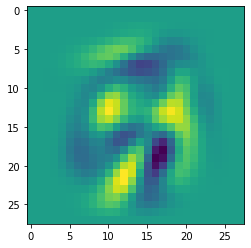

In [66]:
plt.imshow(pca.toArray().T[9].reshape((28,28)))

In [58]:
# Пример формата ответа

import json

ans = [
    [0.1, 0.55, 0.23, 0.34],  # Первая главная компонента - 784 числа в массиве (вместо 4, которые в примере)
    [0.2, 0.3, 0.4, 0.5],  # Вторая компонента - также 784 числа в массиве
    # И так далее - всего должно быть 10 компонент упорядоченных в порядке информативности 
]

with open('result.json', 'w') as f:
    f.write(json.dumps(pca.components_.tolist()))

In [21]:
! cat result.json

[[0.1, 0.55, 0.23, 0.34], [0.2, 0.3, 0.4, 0.5]]

Дополнительное задание без оценивания - визуализируйте полученные компоненты. Так как найденные компоненты - это также вектора длинной 784, то мы также можем их нарисовать как картинки и посмотреть, какие регионы картинки являются наиболее информативными.

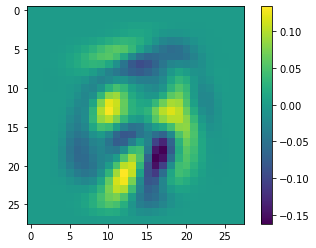

In [51]:
plt.imshow(pca.components_[9].reshape((28, 28)))
plt.colorbar()